In [ ]:
# default_exp engine.psf

In [ ]:
%load_ext autoreload
%autoreload 2

# PSF model

> Definition of the classes and modules we use to model PSFs

In [ ]:
#export
from decode_fish.imports import *
import torch.nn as nn
from torch.jit import script
from typing import Union, List
import torch.nn.functional as F
from decode_fish.funcs.utils import *
from decode_fish.funcs.plotting import *

In [ ]:
#export
class LinearInterpolatedPSF(nn.Module):
    """
    Linearly interpolates psf volume with offsets
    """

    def __init__(self, size_zyx, device='cuda'):
        super().__init__()
        
        self.psf_size = list(np.array(size_zyx).astype('int'))
        # +- /sz so that the values correspond to the pixel centers
        v = [torch.linspace(-1+1/sz, 1-1/sz, int(sz)) for sz in self.psf_size]

        self.register_buffer('x', v[2])
        self.register_buffer('y', v[1])
        self.register_buffer('z', v[0])
        self.device=device
        self.psf_volume = nn.Parameter(0.01*torch.rand(1, *self.psf_size))
        self.forward_nonlin = torch.nn.Identity()
        
    def forward(self, x_offset_val, y_offset_val, z_offset_val):

        N_em = x_offset_val.shape[0]
        # Scale offsets by size. Factor of two because range [-1,1]
        x_offset = 2 * x_offset_val.view(-1) / self.psf_size[2]  
        y_offset = 2 * y_offset_val.view(-1) / self.psf_size[1]
        z_offset = 2 * z_offset_val.view(-1) / self.psf_size[0]
        i_img, x_grid, y_grid, z_grid = torch.meshgrid(torch.arange(N_em, dtype=torch.float32).to(self.device), self.x.to(self.device), self.y.to(self.device), self.z.to(self.device))

        x_grid = x_grid - x_offset[:, None, None, None]
        y_grid = y_grid - y_offset[:, None, None, None]
        z_grid = z_grid - z_offset[:, None, None, None]

        m_grid = torch.stack([x_grid, y_grid, z_grid], -1)
        psf_out = torch.nn.functional.grid_sample(self.forward_nonlin(self.psf_volume).expand(N_em, -1, -1, -1, -1).to(self.device), m_grid, align_corners = False)
        
        return psf_out.transpose(-3,-1)
    
    def get_com(self):
        
        x_grid, y_grid, z_grid = torch.meshgrid(torch.arange(self.psf_size[0]),torch.arange(self.psf_size[1]),torch.arange(self.psf_size[2]))
        m_grid = torch.stack([x_grid, y_grid, z_grid], -1).to(self.device)
        
        vol = (self.forward_nonlin(self.psf_volume[0])**2).to(self.device)

        zc = (m_grid[:,:,:,0] * vol).sum()/vol.sum()
        yc = (m_grid[:,:,:,1] * vol).sum()/vol.sum()
        xc = (m_grid[:,:,:,2] * vol).sum()/vol.sum()
        
        return zc, yc, xc
#         return torch.stack((zc, yc, xc)).to(self.device)
    
    def com_loss(self):
        
        return torch.norm(torch.stack(self.get_com()) - torch.tensor(self.psf_size).to(self.device)//2, 2)
    
    def clip_loss(self):
        
        return torch.norm(torch.nn.ReLU().forward(-self.psf_volume).sum(), 2)
    
    def sum_loss(self, target=1):
        
        return torch.norm(self.forward_nonlin(self.psf_volume).sum() - 1, 2)

In [ ]:
#export
def crop_psf(psf, extent_zyx):

    cropped_vol = center_crop(psf.psf_volume, extent_zyx)
    cropped_psf = LinearInterpolatedPSF(extent_zyx)
    cropped_psf.psf_volume.data = cropped_vol
    
    return cropped_psf

In [ ]:
psf_state = torch.load('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/msp300_smFISH/nb_run/msp300_smFISH_3_3/psf_init.pkl')
shape_zyx = psf_state['psf_volume'][:,].shape[-3:]
psf = LinearInterpolatedPSF([13,21,21])
psf.psf_volume.data = psf_state['psf_volume'][:,]

In [ ]:
psf.psf_volume[0].shape

torch.Size([21, 21, 21])

In [ ]:
psf.get_com()

RuntimeError: The size of tensor a (13) must match the size of tensor b (21) at non-singleton dimension 0

torch.Size([1, 1, 13, 21, 21])

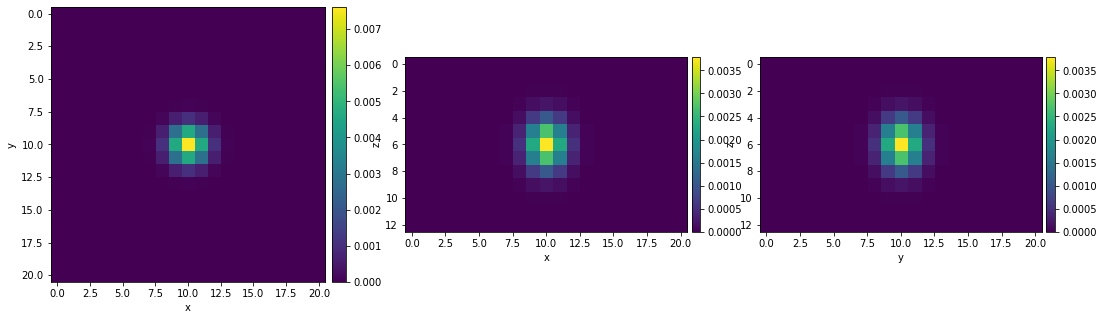

In [ ]:
shift = psf(torch.tensor([-2,0.,+2]).cuda(),0.+torch.zeros(3).cuda(),0.+torch.zeros(3).cuda())
shift = psf(0.+torch.zeros(1).cuda(),0.+torch.zeros(1).cuda(),0.+torch.zeros(1).cuda())
plot_3d_projections(cpu(shift)[0,0])
shift.shape

In [ ]:
cropped_psf = crop_psf(psf,[11,21,21])

torch.Size([1, 11, 21, 21])
torch.Size([21]) torch.Size([21]) torch.Size([11])


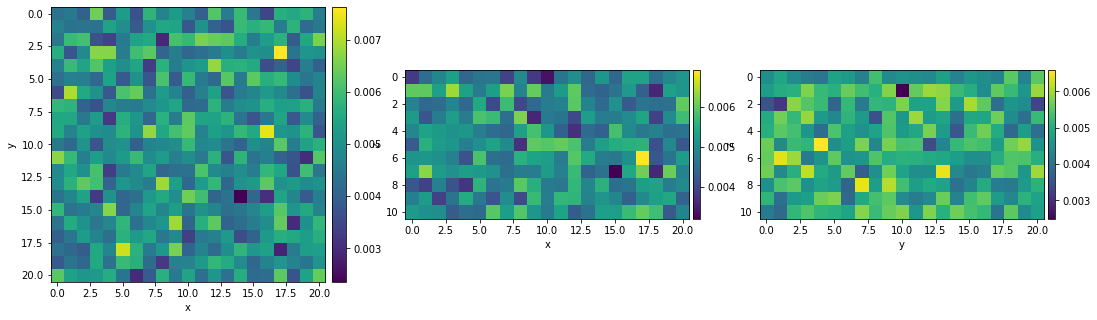

In [ ]:
plot_3d_projections(cpu(cropped_psf.psf_volume)[0])
print(cropped_psf.psf_volume.shape)
print(cropped_psf.x.shape,cropped_psf.y.shape,cropped_psf.z.shape)

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted 17_eval_routines.ipynb.
Converted index.ipynb.
